# Exploration des données pour la détection de pneumonie

Ce notebook permet d'explorer les données d'images radiographiques pour la détection de pneumonie.

In [1]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

# Pour éviter les avertissements
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Chargement des données

Nous allons d'abord définir le chemin vers les données et explorer la structure des dossiers.

In [2]:
# Définir le chemin vers les données
# Remplacez ce chemin par le chemin réel vers vos données
data_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data'

# Vérifier si le répertoire existe
if not os.path.exists(data_dir):
    print(f"Le répertoire {data_dir} n'existe pas.")
else:
    # Explorer la structure des dossiers
    print("Structure des dossiers:")
    for root, dirs, files in os.walk(data_dir):
        level = root.replace(data_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Afficher seulement les 5 premiers fichiers
            print(f"{sub_indent}{f}")
        if len(files) > 5:
            print(f"{sub_indent}... ({len(files) - 5} autres fichiers)")

Structure des dossiers:
data/
    test/
        .DS_Store
        NORMAL/
            IM-0001-0001.jpeg
            IM-0003-0001.jpeg
            IM-0005-0001.jpeg
            IM-0006-0001.jpeg
            IM-0007-0001.jpeg
            ... (229 autres fichiers)
        PNEUMONIA/
            person100_bacteria_475.jpeg
            person100_bacteria_477.jpeg
            person100_bacteria_478.jpeg
            person100_bacteria_479.jpeg
            person100_bacteria_480.jpeg
            ... (385 autres fichiers)
    train/
        NORMAL/
            IM-0115-0001.jpeg
            IM-0117-0001.jpeg
            IM-0119-0001.jpeg
            IM-0122-0001.jpeg
            IM-0125-0001.jpeg
            ... (1336 autres fichiers)
        PNEUMONIA/
            person1000_bacteria_2931.jpeg
            person1000_virus_1681.jpeg
            person1001_bacteria_2932.jpeg
            person1002_bacteria_2933.jpeg
            person1003_bacteria_2934.jpeg
            ... (3870 autres fichiers)


## 2. Fonctions utilitaires pour charger et visualiser les images

In [3]:
def load_images_from_dir(directory, img_size=(224, 224), max_images=None):
    """
    Charge les images d'un répertoire avec leurs étiquettes.
    
    Args:
        directory (str): Chemin vers le répertoire contenant les images
        img_size (tuple): Taille des images après redimensionnement
        max_images (int): Nombre maximum d'images à charger par classe
        
    Returns:
        tuple: Images, étiquettes et noms de fichiers
    """
    images = []
    labels = []
    filenames = []
    
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return np.array([]), np.array([]), []
    
    # Parcourir les sous-répertoires (classes)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Déterminer l'étiquette (0 pour normal, 1 pour pneumonie)
        label = 0 if class_name.lower() == 'normal' else 1
        
        # Parcourir les images dans le sous-répertoire
        img_count = 0
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            if max_images is not None and img_count >= max_images:
                break
                
            img_path = os.path.join(class_dir, img_name)
            
            # Charger et prétraiter l'image
            try:
                img = cv2.imread(img_path)
                if img is None:  # Vérifier si l'image a été chargée correctement
                    print(f"Impossible de charger l'image {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
                img = cv2.resize(img, img_size)  # Redimensionner
                
                images.append(img)
                labels.append(label)
                filenames.append(img_path)
                img_count += 1
            except Exception as e:
                print(f"Erreur lors du chargement de l'image {img_path}: {e}")
    
    return np.array(images), np.array(labels), filenames

def visualize_images(images, labels, filenames, num_images=5):
    """
    Visualise un échantillon d'images avec leurs étiquettes.
    
    Args:
        images (numpy.ndarray): Images à visualiser
        labels (numpy.ndarray): Étiquettes des images
        filenames (list): Noms des fichiers
        num_images (int): Nombre d'images à visualiser
    """
    if len(images) == 0:
        print("Aucune image à visualiser.")
        return
    
    # Sélectionner des indices aléatoires
    indices = np.random.choice(len(images), min(num_images, len(images)), replace=False)
    
    # Créer une figure avec plusieurs sous-graphiques
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    if len(indices) == 1:
        axes = [axes]
    
    # Afficher chaque image
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"{'Normal' if labels[idx] == 0 else 'Pneumonie'}")
        axes[i].axis('off')
        # Ajouter le nom du fichier en bas
        filename = os.path.basename(filenames[idx])
        axes[i].text(0.5, -0.15, filename, transform=axes[i].transAxes, 
                     ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## 3. Chargement et visualisation d'un échantillon d'images

Nombre d'images chargées: 20
Dimensions des images: (224, 224, 3)


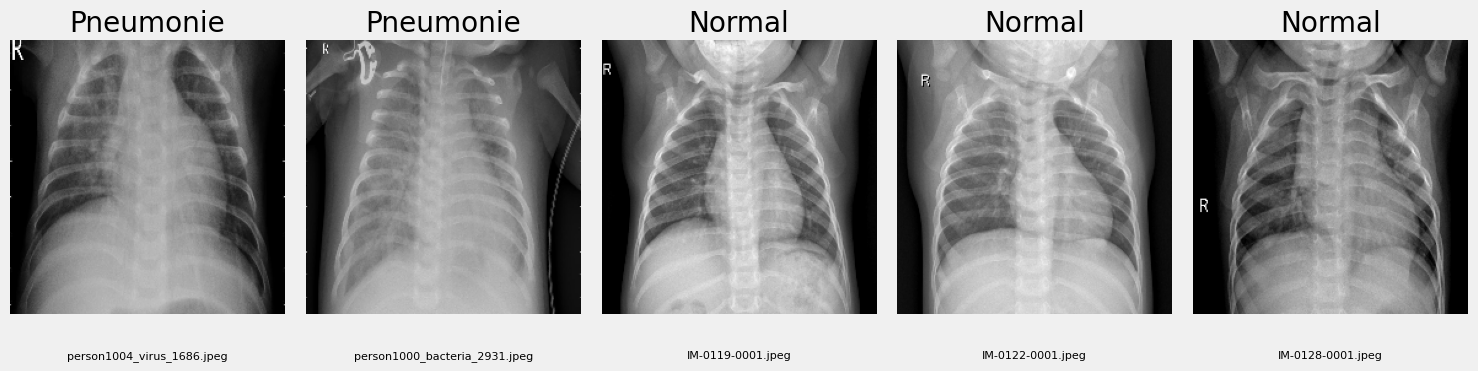

In [4]:
# Charger un échantillon d'images du dossier train (10 par classe)
train_dir = os.path.join(data_dir, 'train')
images, labels, filenames = load_images_from_dir(train_dir, max_images=10)

# Afficher le nombre d'images chargées
print(f"Nombre d'images chargées: {len(images)}")
if len(images) > 0:
    print(f"Dimensions des images: {images.shape[1:]}")
else:
    print("Aucune image n'a été chargée.")

# Visualiser quelques images
visualize_images(images, labels, filenames, num_images=5)

## 4. Analyse de la distribution des classes

Distribution des images par classe :

Ensemble TRAIN :
  - Images NORMAL : 1341
  - Images PNEUMONIA : 3875
  - Total : 5216 images
  - Distribution : 25.7% NORMAL, 74.3% PNEUMONIA

Ensemble TEST :
  - Images NORMAL : 234
  - Images PNEUMONIA : 390
  - Total : 624 images
  - Distribution : 37.5% NORMAL, 62.5% PNEUMONIA

Ensemble VAL :
  - Images NORMAL : 8
  - Images PNEUMONIA : 8
  - Total : 16 images
  - Distribution : 50.0% NORMAL, 50.0% PNEUMONIA

TOTAL GLOBAL :
  - Images NORMAL : 1583
  - Images PNEUMONIA : 4273
  - Total : 5856 images
  - Distribution globale : 27.0% NORMAL, 73.0% PNEUMONIA


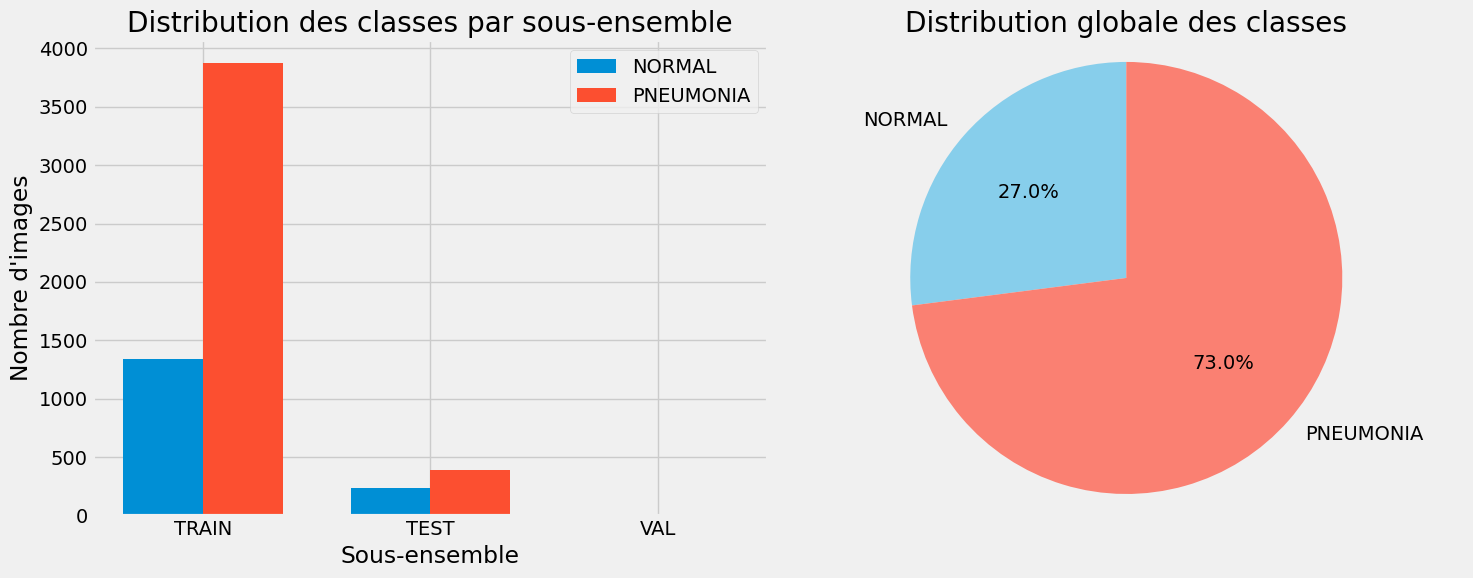

In [5]:
def count_images_by_class(data_dir):
    """
    Compte le nombre d'images par classe dans chaque sous-ensemble.
    
    Args:
        data_dir (str): Chemin vers le répertoire de données
        
    Returns:
        dict: Dictionnaire contenant le nombre d'images par classe et par sous-ensemble
    """
    counts = {}
    
    for subset in ['train', 'test', 'val']:
        subset_dir = os.path.join(data_dir, subset)
        if not os.path.exists(subset_dir):
            continue
            
        counts[subset] = {}
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(subset_dir, class_name)
            if not os.path.exists(class_dir):
                counts[subset][class_name] = 0
                continue
                
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            counts[subset][class_name] = len(image_files)
    
    return counts

# Compter les images
counts = count_images_by_class(data_dir)

# Afficher les résultats
print("Distribution des images par classe :")
print("=" * 50)

total_normal = 0
total_pneumonia = 0

for subset, classes in counts.items():
    normal_count = classes.get('NORMAL', 0)
    pneumonia_count = classes.get('PNEUMONIA', 0)
    total_subset = normal_count + pneumonia_count
    
    total_normal += normal_count
    total_pneumonia += pneumonia_count
    
    print(f"\nEnsemble {subset.upper()} :")
    print(f"  - Images NORMAL : {normal_count}")
    print(f"  - Images PNEUMONIA : {pneumonia_count}")
    print(f"  - Total : {total_subset} images")
    
    if total_subset > 0:
        normal_percent = (normal_count / total_subset) * 100
        pneumonia_percent = (pneumonia_count / total_subset) * 100
        print(f"  - Distribution : {normal_percent:.1f}% NORMAL, {pneumonia_percent:.1f}% PNEUMONIA")

# Afficher le total global
total_all = total_normal + total_pneumonia
print("\nTOTAL GLOBAL :")
print(f"  - Images NORMAL : {total_normal}")
print(f"  - Images PNEUMONIA : {total_pneumonia}")
print(f"  - Total : {total_all} images")

if total_all > 0:
    normal_percent = (total_normal / total_all) * 100
    pneumonia_percent = (total_pneumonia / total_all) * 100
    print(f"  - Distribution globale : {normal_percent:.1f}% NORMAL, {pneumonia_percent:.1f}% PNEUMONIA")

# Visualiser la distribution avec un graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique par sous-ensemble
subsets = list(counts.keys())
normal_counts = [counts[subset].get('NORMAL', 0) for subset in subsets]
pneumonia_counts = [counts[subset].get('PNEUMONIA', 0) for subset in subsets]

x = range(len(subsets))
width = 0.35

ax1.bar([i - width/2 for i in x], normal_counts, width, label='NORMAL')
ax1.bar([i + width/2 for i in x], pneumonia_counts, width, label='PNEUMONIA')

ax1.set_xlabel('Sous-ensemble')
ax1.set_ylabel('Nombre d\'images')
ax1.set_title('Distribution des classes par sous-ensemble')
ax1.set_xticks(x)
ax1.set_xticklabels([s.upper() for s in subsets])
ax1.legend()

# Graphique global
ax2.pie([total_normal, total_pneumonia], 
        labels=['NORMAL', 'PNEUMONIA'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'])
ax2.axis('equal')
ax2.set_title('Distribution globale des classes')

plt.tight_layout()
plt.show()

## 5. Analyse des caractéristiques des images


Aperçu des propriétés des images :
   width  height  aspect_ratio     size_kb   class subset
0   1518    1302      1.165899  442.991211  NORMAL  train
1   1264     950      1.330526  340.369141  NORMAL  train
2   1244    1005      1.237811  377.906250  NORMAL  train
3   1570    1156      1.358131  465.262695  NORMAL  train
4   1882    1855      1.014555  922.571289  NORMAL  train

Statistiques descriptives :
             width       height  aspect_ratio      size_kb
count   136.000000   136.000000    136.000000   136.000000
mean   1430.294118  1051.007353      1.430967   221.021448
std     410.417351   409.684766      0.251244   248.222766
min     527.000000   219.000000      1.014555    11.116211
25%    1152.000000   739.000000      1.249085    62.355713
50%    1344.000000  1010.500000      1.401607   118.366211
75%    1696.500000  1240.500000      1.540622   289.051758
max    2746.000000  2382.000000      2.406393  1793.771484

Statistiques par classe :
                 width       

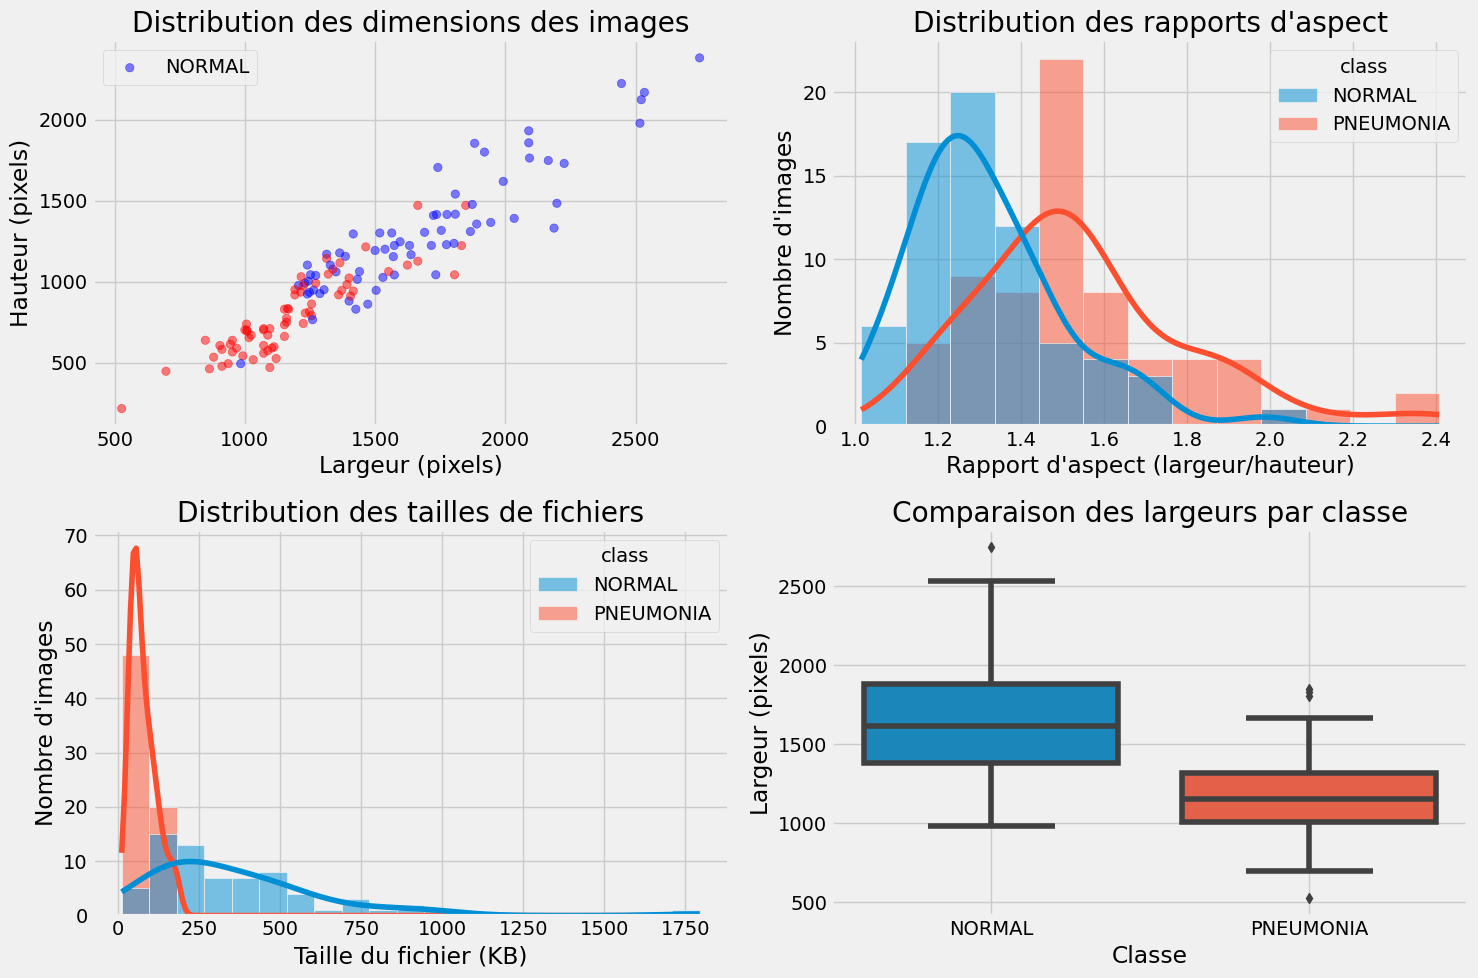

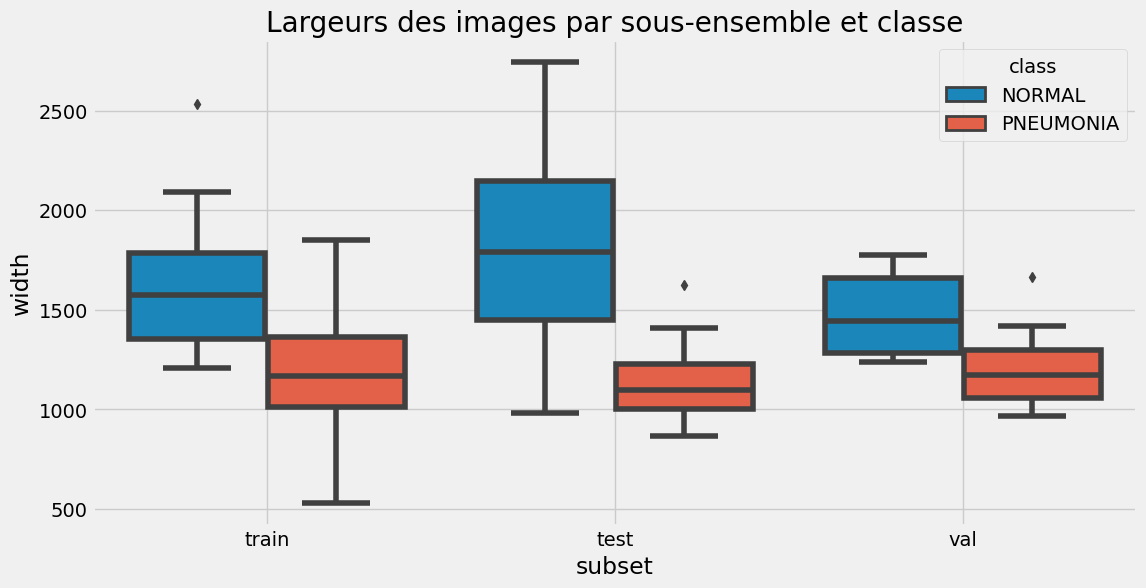

In [6]:
def analyze_image_properties(data_dir, max_images_per_class=30):
    """
    Analyse les propriétés des images (taille, forme, etc.) dans tous les sous-ensembles
    
    Args:
        data_dir (str): Chemin vers le répertoire de données
        max_images_per_class (int): Nombre maximum d'images à analyser par classe
        
    Returns:
        pandas.DataFrame: DataFrame contenant les propriétés des images
    """
    properties = {
        'width': [],
        'height': [],
        'aspect_ratio': [],
        'size_kb': [],
        'class': [],
        'subset': []
    }
    
    for subset in ['train', 'test', 'val']:
        subset_dir = os.path.join(data_dir, subset)
        if not os.path.exists(subset_dir):
            continue
            
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(subset_dir, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if not image_files:
                continue
                
            # Sélectionner un échantillon aléatoire
            import random
            selected_files = random.sample(image_files, min(max_images_per_class, len(image_files)))
            
            for img_file in selected_files:
                img_path = os.path.join(class_dir, img_file)
                try:
                    # Obtenir la taille du fichier en KB
                    size_kb = os.path.getsize(img_path) / 1024
                    
                    # Charger l'image et obtenir ses dimensions
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Impossible de charger l'image {img_path}")
                        continue
                        
                    height, width = img.shape[:2]
                    aspect_ratio = width / height
                    
                    # Stocker les propriétés
                    properties['width'].append(width)
                    properties['height'].append(height)
                    properties['aspect_ratio'].append(aspect_ratio)
                    properties['size_kb'].append(size_kb)
                    properties['class'].append(class_name)
                    properties['subset'].append(subset)
                except Exception as e:
                    print(f"Erreur lors de l'analyse de {img_path}: {e}")
    
    # Convertir en DataFrame pour faciliter l'analyse
    df_properties = pd.DataFrame(properties)
    return df_properties

# Analyser les propriétés des images
image_properties = analyze_image_properties(data_dir)

# Afficher un aperçu des propriétés
if not image_properties.empty:
    print("\nAperçu des propriétés des images :")
    print("=" * 50)
    print(image_properties.head())
    
    # Statistiques descriptives
    print("\nStatistiques descriptives :")
    print("=" * 50)
    print(image_properties.describe())
    
    # Statistiques par classe
    print("\nStatistiques par classe :")
    print("=" * 50)
    # Sélectionner uniquement les colonnes numériques pour le calcul de la moyenne
    numeric_cols = ['width', 'height', 'aspect_ratio', 'size_kb']
    print(image_properties.groupby('class')[numeric_cols].mean())
    
    # Statistiques par sous-ensemble
    print("\nStatistiques par sous-ensemble :")
    print("=" * 50)
    # Sélectionner uniquement les colonnes numériques pour le calcul de la moyenne
    print(image_properties.groupby('subset')[numeric_cols].mean())
    
    # Visualiser les propriétés
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des dimensions
    axes[0, 0].scatter(image_properties['width'], image_properties['height'], 
                      c=['blue' if c == 'NORMAL' else 'red' for c in image_properties['class']], 
                      alpha=0.5)
    axes[0, 0].set_xlabel('Largeur (pixels)')
    axes[0, 0].set_ylabel('Hauteur (pixels)')
    axes[0, 0].set_title('Distribution des dimensions des images')
    axes[0, 0].legend(['NORMAL', 'PNEUMONIA'])
    axes[0, 0].grid(True)
    
    # Distribution des rapports d'aspect
    sns.histplot(data=image_properties, x='aspect_ratio', hue='class', kde=True, ax=axes[0, 1])
    axes[0, 1].set_xlabel('Rapport d\'aspect (largeur/hauteur)')
    axes[0, 1].set_ylabel('Nombre d\'images')
    axes[0, 1].set_title('Distribution des rapports d\'aspect')
    axes[0, 1].grid(True)
    
    # Distribution des tailles de fichiers
    sns.histplot(data=image_properties, x='size_kb', hue='class', kde=True, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Taille du fichier (KB)')
    axes[1, 0].set_ylabel('Nombre d\'images')
    axes[1, 0].set_title('Distribution des tailles de fichiers')
    axes[1, 0].grid(True)
    
    # Boîtes à moustaches des dimensions par classe
    sns.boxplot(data=image_properties, x='class', y='width', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Classe')
    axes[1, 1].set_ylabel('Largeur (pixels)')
    axes[1, 1].set_title('Comparaison des largeurs par classe')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Visualiser les dimensions par sous-ensemble
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=image_properties, x='subset', y='width', hue='class')
    plt.title('Largeurs des images par sous-ensemble et classe')
    plt.grid(True)
    plt.show()
else:
    print("Aucune propriété d'image n'a été collectée.")

## 6. Analyse des intensités de pixels

Analyse de 30 images normales et 30 images de pneumonie

Intensité moyenne des pixels:
- Normal: 120.39 (écart-type: 62.49)
- Pneumonie: 123.42 (écart-type: 59.48)


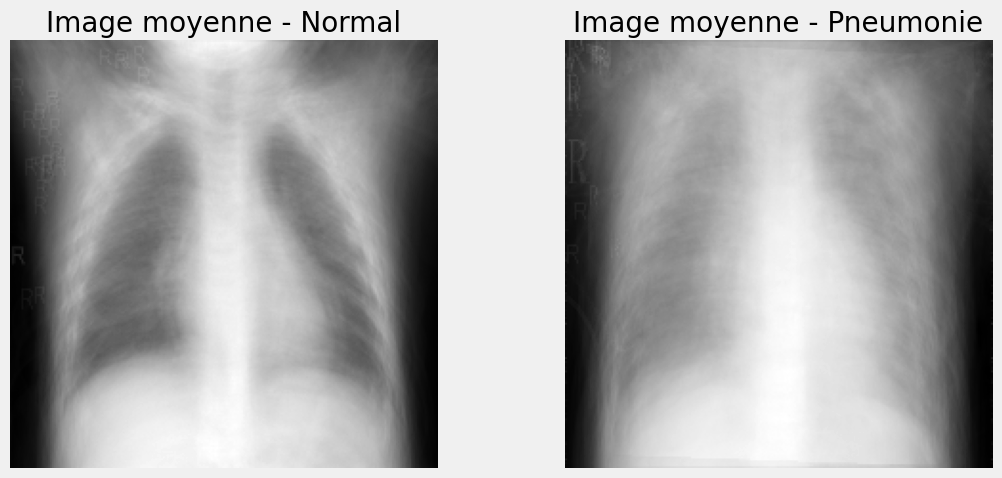

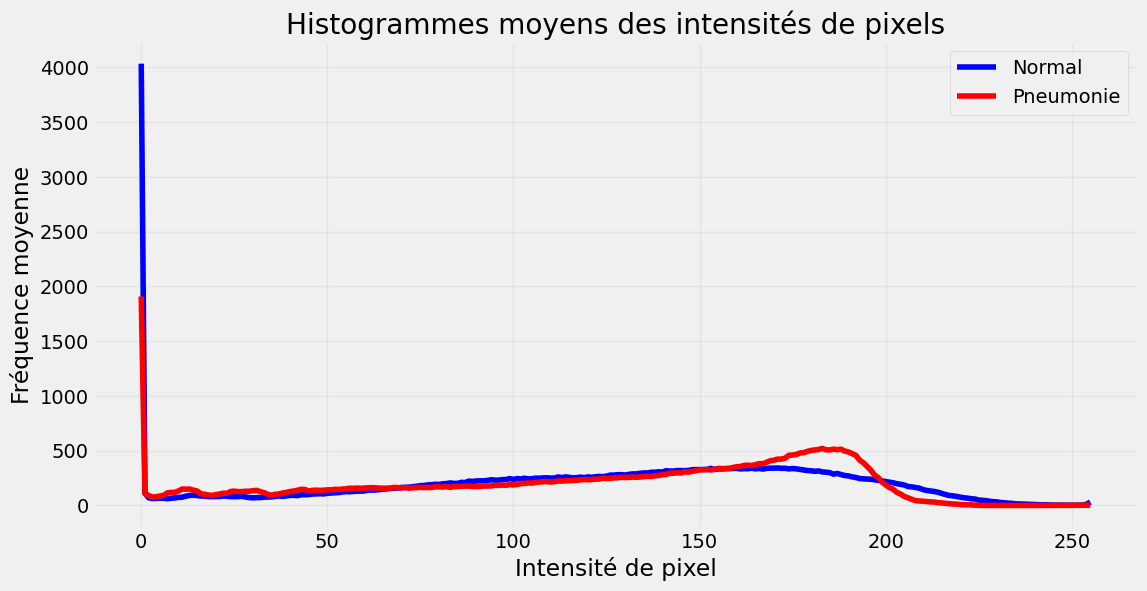

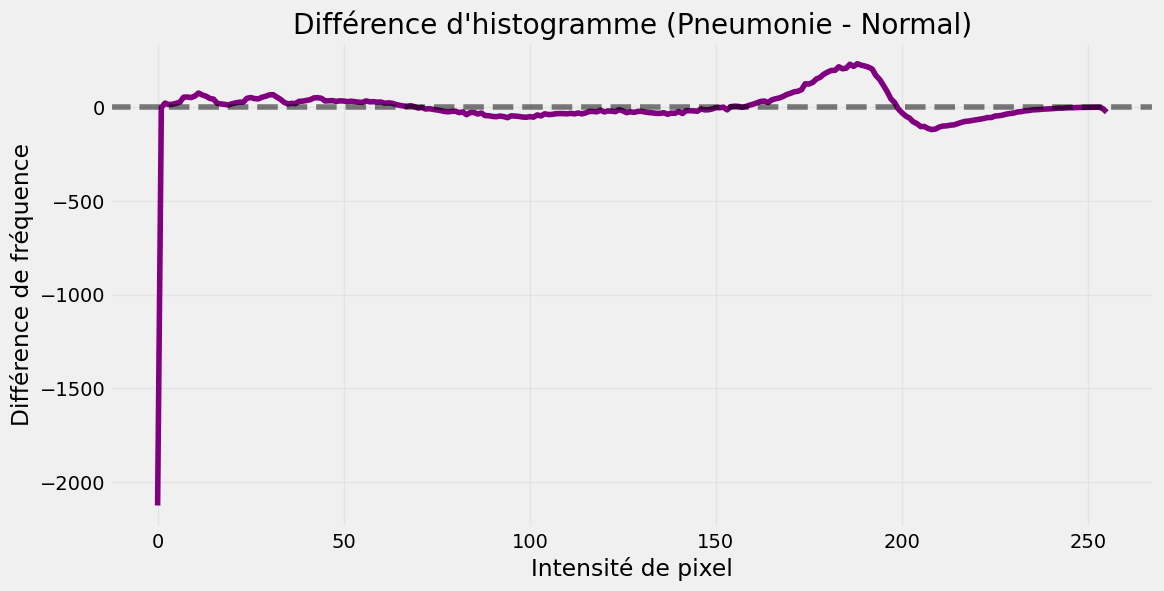

In [7]:
def analyze_pixel_intensities(images, labels):
    """
    Analyse les intensités de pixels des images par classe.
    
    Args:
        images (numpy.ndarray): Images à analyser
        labels (numpy.ndarray): Étiquettes des images
    """
    if len(images) == 0:
        print("Aucune image à analyser.")
        return
    
    # Vérifier qu'il y a des images dans chaque classe
    if not np.any(labels == 0) or not np.any(labels == 1):
        print("Il manque des images dans une des classes.")
        return
    
    # Convertir les images en niveaux de gris
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    
    # Séparer les images par classe
    normal_images = gray_images[labels == 0]
    pneumonia_images = gray_images[labels == 1]
    
    print(f"Analyse de {len(normal_images)} images normales et {len(pneumonia_images)} images de pneumonie")
    
    # Calculer les moyennes par classe
    normal_mean = np.mean(normal_images, axis=0)
    pneumonia_mean = np.mean(pneumonia_images, axis=0)
    
    # Calculer les statistiques de base
    normal_avg_intensity = np.mean(normal_images)
    pneumonia_avg_intensity = np.mean(pneumonia_images)
    normal_std_intensity = np.std(normal_images)
    pneumonia_std_intensity = np.std(pneumonia_images)
    
    print(f"\nIntensité moyenne des pixels:")
    print(f"- Normal: {normal_avg_intensity:.2f} (écart-type: {normal_std_intensity:.2f})")
    print(f"- Pneumonie: {pneumonia_avg_intensity:.2f} (écart-type: {pneumonia_std_intensity:.2f})")
    
    # Calculer les histogrammes moyens
    normal_hist = np.mean([cv2.calcHist([img], [0], None, [256], [0, 256]) for img in normal_images], axis=0).flatten()
    pneumonia_hist = np.mean([cv2.calcHist([img], [0], None, [256], [0, 256]) for img in pneumonia_images], axis=0).flatten()
    
    # Visualiser les images moyennes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(normal_mean, cmap='gray')
    axes[0].set_title('Image moyenne - Normal')
    axes[0].axis('off')
    
    axes[1].imshow(pneumonia_mean, cmap='gray')
    axes[1].set_title('Image moyenne - Pneumonie')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Visualiser les histogrammes moyens
    plt.figure(figsize=(12, 6))
    plt.plot(normal_hist, color='blue', label='Normal')
    plt.plot(pneumonia_hist, color='red', label='Pneumonie')
    plt.title('Histogrammes moyens des intensités de pixels')
    plt.xlabel('Intensité de pixel')
    plt.ylabel('Fréquence moyenne')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualiser la différence entre les histogrammes
    plt.figure(figsize=(12, 6))
    plt.plot(pneumonia_hist - normal_hist, color='purple')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Différence d\'histogramme (Pneumonie - Normal)')
    plt.xlabel('Intensité de pixel')
    plt.ylabel('Différence de fréquence')
    plt.grid(True, alpha=0.3)
    plt.show()

# Charger des images pour l'analyse des pixels
train_dir = os.path.join(data_dir, 'train')
train_images, train_labels, _ = load_images_from_dir(train_dir, max_images=30)

# Analyser les intensités de pixels
analyze_pixel_intensities(train_images, train_labels)

## 7. Préparation des données pour l'entraînement

Chargement des images pour la préparation des données...
Données préparées: 128 images d'entraînement, 32 images de validation, 40 images de test

Distribution des classes:
Entraînement: 64 normales (50.0%), 64 pneumonies (50.0%)
Validation: 16 normales (50.0%), 16 pneumonies (50.0%)
Test: 20 normales (50.0%), 20 pneumonies (50.0%)


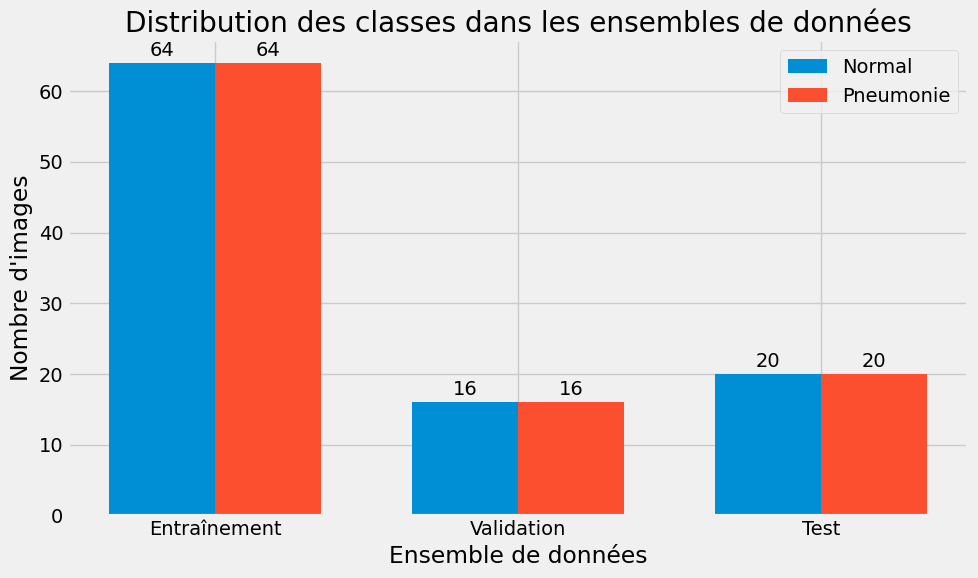

In [8]:
def prepare_data_for_training(images, labels, test_size=0.2, val_size=0.2):
    """
    Prépare les données pour l'entraînement en les divisant en ensembles d'entraînement, de validation et de test.
    
    Args:
        images (numpy.ndarray): Images à préparer
        labels (numpy.ndarray): Étiquettes des images
        test_size (float): Proportion des données pour le test
        val_size (float): Proportion des données d'entraînement pour la validation
        
    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test
    """
    if len(images) == 0:
        print("Aucune image à préparer.")
        return None, None, None, None, None, None
    
    # Normaliser les images
    normalized_images = images / 255.0
    
    # Diviser en ensembles d'entraînement et de test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        normalized_images, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Diviser l'ensemble d'entraînement en entraînement et validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
    )
    
    print(f"Données préparées: {len(X_train)} images d'entraînement, {len(X_val)} images de validation, {len(X_test)} images de test")
    
    # Afficher la distribution des classes dans chaque ensemble
    print("\nDistribution des classes:")
    train_counts = np.bincount(y_train)
    val_counts = np.bincount(y_val)
    test_counts = np.bincount(y_test)
    
    print(f"Entraînement: {train_counts[0]} normales ({train_counts[0]/len(y_train)*100:.1f}%), {train_counts[1]} pneumonies ({train_counts[1]/len(y_train)*100:.1f}%)")
    print(f"Validation: {val_counts[0]} normales ({val_counts[0]/len(y_val)*100:.1f}%), {val_counts[1]} pneumonies ({val_counts[1]/len(y_val)*100:.1f}%)")
    print(f"Test: {test_counts[0]} normales ({test_counts[0]/len(y_test)*100:.1f}%), {test_counts[1]} pneumonies ({test_counts[1]/len(y_test)*100:.1f}%)")
    
    # Visualiser la distribution des classes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = ['Entraînement', 'Validation', 'Test']
    normal_counts = [train_counts[0], val_counts[0], test_counts[0]]
    pneumonia_counts = [train_counts[1], val_counts[1], test_counts[1]]
    
    width = 0.35
    x_pos = np.arange(len(x))
    
    ax.bar(x_pos - width/2, normal_counts, width, label='Normal')
    ax.bar(x_pos + width/2, pneumonia_counts, width, label='Pneumonie')
    
    ax.set_xlabel('Ensemble de données')
    ax.set_ylabel('Nombre d\'images')
    ax.set_title('Distribution des classes dans les ensembles de données')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(normal_counts):
        ax.text(i - width/2, v + 1, str(v), ha='center')
    
    for i, v in enumerate(pneumonia_counts):
        ax.text(i + width/2, v + 1, str(v), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Charger toutes les images pour la préparation des données
print("Chargement des images pour la préparation des données...")
train_dir = os.path.join(data_dir, 'train')
all_images, all_labels, _ = load_images_from_dir(train_dir, max_images=100)  # Limité à 100 par classe pour l'exemple

# Préparer les données pour l'entraînement
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_training(all_images, all_labels)

## 8. Conclusion et prochaines étapes

Dans ce notebook, nous avons exploré les données d'images radiographiques pour la détection de pneumonie. Nous avons :
1. Chargé et visualisé un échantillon d'images
2. Analysé la distribution des classes
3. Examiné les propriétés des images (dimensions, taille, etc.)
4. Analysé les intensités de pixels
5. Préparé les données pour l'entraînement

Les prochaines étapes consisteront à :
1. Créer et entraîner différents modèles de deep learning
2. Évaluer les performances des modèles
3. Optimiser les hyperparamètres
4. Comparer les résultats des différentes approches

Ces étapes seront abordées dans les notebooks suivants.